In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel("/content/drive/MyDrive/ubos_yield.xlsx")
df.head()

,years,region,area planted,area harvested,production,yield(MT/ha),yield(MT/ha).1,rainfall,TEMPERATURE
0,2019-01-01,South Buganda,89328,85168.0,127887,1.5,1.4,137.110000,23.223333
1,2019-01-01,North Buganda,198285,175282.0,283621,1.6,1.4,137.110000,23.223333
2,2019-01-01,West Nile,43766,37465.0,45271,1.2,1.0,121.290000,28.046667
3,2019-01-01,Lango,79683,75210.0,92444,1.2,1.2,61.523333,27.100000
4,2019-01-01,Acholi,76779,64740.0,58407,0.9,0.8,68.556667,27.776667


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   years           84 non-null     datetime64[ns]
 1   region          84 non-null     object        
 2   area planted    84 non-null     int64         
 3   area harvested  70 non-null     float64       
 4   production      84 non-null     int64         
 5   yield(MT/ha)    84 non-null     float64       
 6   yield(MT/ha).1  56 non-null     float64       
 7   rainfall        84 non-null     float64       
 8   TEMPERATURE     84 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 6.0+ KB


In [4]:
# Remove the specified columns
columns_to_remove = ["area harvested", "area harvested", "yield(MT/ha).1", "production", "region"]
df2 = df.drop(columns=columns_to_remove)
df2.head()

,years,area planted,yield(MT/ha),rainfall,TEMPERATURE
0,2019-01-01,89328,1.5,137.110000,23.223333
1,2019-01-01,198285,1.6,137.110000,23.223333
2,2019-01-01,43766,1.2,121.290000,28.046667
3,2019-01-01,79683,1.2,61.523333,27.100000
4,2019-01-01,76779,0.9,68.556667,27.776667


In [5]:
# Sort the dataframe by date
df2 = df2.sort_values('years')

In [6]:
X = df2.drop(['yield(MT/ha)', 'years'], axis=1)
y = df2['yield(MT/ha)']
dates = df2['years']

In [7]:
# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Display the shape of the scaled features
print("Shape of scaled features:", X_scaled.shape)

# Display the first few rows of the scaled data
print(pd.DataFrame(X_scaled).head())


Shape of scaled features: (84, 3)
          0         1         2
0  0.023623  0.081302  0.133421
1  1.000000  0.085368  0.380216
2  0.482685  0.104674  0.416893
3  0.203513  0.153456  0.466936
4  0.245517  0.129066  0.030228


In [8]:
# Create sequences for LSTM
sequence_length = 5  # Adjust this based on your needs
X_sequences = []
y_sequences = []
dates_sequences = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y.iloc[i+sequence_length])
    dates_sequences.append(dates.iloc[i+sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [19]:
print('trainX shape == {}.'.format(X_sequences.shape))
print('trainY shape == {}.'.format(y_sequences.shape))

trainX shape == (79, 5, 3).
trainY shape == (79,).


In [9]:
# Split the data
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_sequences, y_sequences, dates_sequences, test_size=0.2, random_state=42, shuffle=False)

In [11]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_sequences.shape[1], X_sequences.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 64)               │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.5109 - val_loss: 3.5009
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.6597 - val_loss: 3.3464
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.4061 - val_loss: 3.1819
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.2202 - val_loss: 2.9919
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0080 - val_loss: 2.7721
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8712 - val_loss: 2.5222
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8094 - val_loss: 2.2393
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6410 - val_loss: 1.9232
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2138 - val_loss: 1.5748
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9951 - val_loss: 1.2003
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6234 - val_loss: 0.8259
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5883 - val_loss

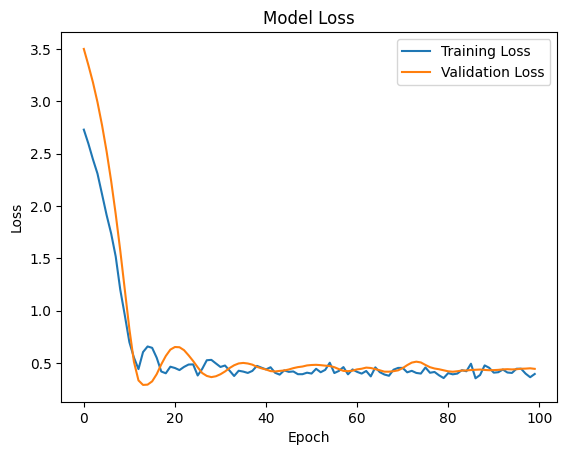

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [14]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}')


Test loss: 4.835407257080078


In [15]:
# Make predictions
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error
mse = mean_squared_error(y_test,predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared (R²) score
r2 = r2_score(y_test,predictions)
print(f'R-squared (R²) Score: {r2}')

Mean Squared Error: 4.835407472660858
R-squared (R²) Score: -1.166257132109234


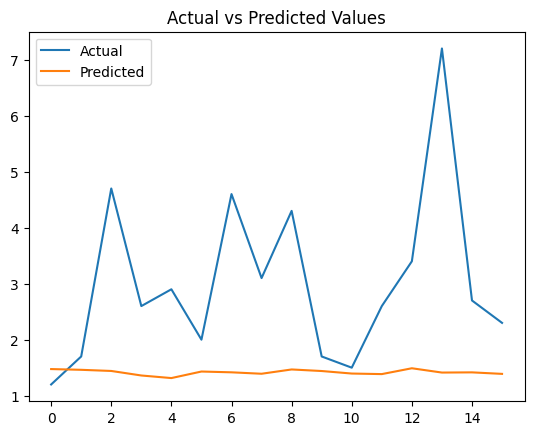

In [17]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for the test set
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()


In [20]:
# Print some sample predictions
print("Sample predictions:")
for date, actual, pred in zip(dates_test[:5], y_test[:5], predictions[:5]):
    print(f"Date: {date}, Actual: {actual}, Predicted: {pred[0]}")

Sample predictions:
Date: 2020-01-01 00:00:00, Actual: 1.2, Predicted: 1.4751777648925781
Date: 2020-01-01 00:00:00, Actual: 1.7, Predicted: 1.4618616104125977
Date: 2020-02-01 00:00:00, Actual: 4.7, Predicted: 1.4413896799087524
Date: 2020-02-01 00:00:00, Actual: 2.6, Predicted: 1.3604902029037476
Date: 2020-02-01 00:00:00, Actual: 2.9, Predicted: 1.3143783807754517
